In [1]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp
import numpy.linalg as LA
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from scipy.ndimage import gaussian_filter

In [2]:
def pole_correct_UV(dax, day, x="longitude", y="latitude"):
    """
    Correct U and V data so that it will plot nicely at the pole

    Parameters
    ----------
    dax, day : xarray.DataArray
        DataArrays for the x and y component of the vector arrow
    x : str, default 'longitude'
        Longitude coordinate name
    y : str, default 'latitude'
        Latitude coordinate name

    Returns
    -------
    bu,bv : corrected U and V components
    """

    lats, lons = dax[y].values, dax[x].values
    lon2d, lat2d = np.meshgrid(lons, lats)

    X, Y = dax.values, day.values

    X_src_crs = X / np.cos(lat2d / 180 * np.pi)
    Y_src_crs = Y
    magnitude = np.sqrt(X**2 + Y**2)
    magn_src_crs = np.sqrt(X_src_crs**2 + Y_src_crs**2)

    bu = X_src_crs * magnitude / magn_src_crs
    bv = Y_src_crs * magnitude / magn_src_crs

    return bu,bv,lon2d,lat2d

In [11]:
def add_streamline_plot_to_ax(dax, day, axs, x="longitude", y="latitude", **figkwargs):
    """
    Add a streamlines plot to a pre-existing set of axes

    Parameters
    ----------
    dax, day : xarray.DataArray
        DataArrays for the x and y component of the vector arrow
    axs : matplotlib.axes.Axes
    x : str, default 'longitude'
        Longitude coordinate name
    y : str, default 'latitude'
        Latitude coordinate name
    **figkwargs : optional
        An assortment of figkwargs. See the matplotlib.pyplot.streamplot documentation for details

    Returns
    -------
    p : matplotlib.pyplot.streamplot
    """



    lats, lons = dax[y].values, dax[x].values
    lon2d, lat2d = np.meshgrid(lons, lats)

    X, Y = dax.values, day.values

    X_src_crs = X / np.cos(lat2d / 180 * np.pi)
    Y_src_crs = Y
    magnitude = np.sqrt(X**2 + Y**2)
    magn_src_crs = np.sqrt(X_src_crs**2 + Y_src_crs**2)

    bu = X_src_crs * magnitude / magn_src_crs
    bv = Y_src_crs * magnitude / magn_src_crs

    lw = 25 * np.sqrt(bu**2 + bv**2)# / np.sqrt(bu**2 + bv**2).max()
    lw = np.nan_to_num(lw, nan=0.0)

    figkwargs = {
        "density": 8,
        "linewidth": lw,
        "arrowsize": 1,
        "color": magnitude,
        "cmap":'viridis',
        **figkwargs,
    }

    p = axs.streamplot(lon2d, lat2d, bu, bv, transform=ccrs.PlateCarree(), **figkwargs)

    cbar = plt.colorbar(p.lines, ax=ax, pad=0.05)
    cbar.set_label("Speed (m/s)")

    plt.title(f"Velocity Streamlines for year {year}")

    return p

In [13]:
ds = xr.open_dataset("/work/scratch-pw5/thopri/cmems_mod_arc_phy_my_topaz4_P1M_vyo-vxo_180.00W-179.88E_50.00N-90.00N_0.00-4000.00m_1991-01-01-2025-08-01.nc")


year = "1994"

u = ds["vxo"].sel(time=year).isel(depth=0).mean("time").compute()  # zonal (east-west)
v = ds["vyo"].sel(time=year).isel(depth=0).mean("time").compute()

u,v,X,Y = pole_correct_UV(u,v)
x = X[0,:]
y = Y[:,0]
# # -------------------------------------------------
# # 1. Create example velocity field WITH SADDLE
# # -------------------------------------------------
# nx, ny = 200, 200
# x = np.linspace(-2, 2, nx)
# y = np.linspace(-2, 2, ny)
# X, Y = np.meshgrid(x, y)
#
# # Streamfunction that has a saddle
# psi = X**2 * Y - (Y**3)/3 + 0.75 * X
#
# # Velocity components
# u =  np.gradient(psi, y, axis=0)   # dψ/dy
# v = -np.gradient(psi, x, axis=1)   # -dψ/dx


In [14]:
# -------------------------------------------------
# 2. Find critical points (u=0 & v=0)
# -------------------------------------------------
fig_tmp, ax_tmp = plt.subplots()
cs_u = ax_tmp.contour(x, y, u, levels=[0])
cs_v = ax_tmp.contour(x, y, v, levels=[0])
plt.close(fig_tmp)

In [15]:
def contour_to_lines(cs):
    lines = []
    # Works across newer matplotlib versions
    for seglist in cs.allsegs:        # list of contour levels
        for seg in seglist:           # each individual contour line
            if len(seg) > 2:          # need at least 2 points
                lines.append(LineString(seg))
    return lines

In [16]:

u_lines = contour_to_lines(cs_u)
v_lines = contour_to_lines(cs_v)

critical_points = []
for ul in u_lines:
    for vl in v_lines:
        inter = ul.intersection(vl)
        if inter.is_empty:
            continue
        if inter.geom_type == "Point":
            critical_points.append((inter.x, inter.y))
# Remove duplicates
critical_points = np.unique(np.round(critical_points, 4), axis=0)
print(f"{critical_points.__len__()} critical points found")

61 critical points found


In [17]:

# -------------------------------------------------
# 3. Compute Jacobian and classify saddles
# -------------------------------------------------
uy, ux = np.gradient(u, y, x)
vy, vx = np.gradient(v, y, x)

interp_ux = RegularGridInterpolator((y, x), ux)
interp_uy = RegularGridInterpolator((y, x), uy)
interp_vx = RegularGridInterpolator((y, x), vx)
interp_vy = RegularGridInterpolator((y, x), vy)
u_interp  = RegularGridInterpolator((y, x), u,bounds_error=False, fill_value=np.nan)
v_interp  = RegularGridInterpolator((y, x), v,bounds_error=False, fill_value=np.nan)

saddles = []

for xc, yc in critical_points:
    J = np.array([
        [interp_ux((yc, xc)), interp_uy((yc, xc))],
        [interp_vx((yc, xc)), interp_vy((yc, xc))]
    ])
    # Skip if any derivative is NaN or inf
    if not np.isfinite(J).all():
        continue

    eigvals, eigvecs = LA.eig(J)

    if np.isreal(eigvals).all() and eigvals[0]*eigvals[1] < 0:
        saddles.append((xc, yc, eigvals.real, eigvecs.real))

print(f"Found {len(saddles)} saddle points")

Found 10 saddle points


In [18]:

# -------------------------------------------------
# 4. Integrate separatrices
# -------------------------------------------------

dx = x[1] - x[0]
dy = y[1] - y[0]

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

import time
t0 = time.time()

def velocity(t, XY):
    x0, y0 = XY
    return [
        float(u_interp((y0, x0))),
        float(v_interp((y0, x0)))
    ]

def velocity_timeout(t, XY):
    if time.time() - t0 > 30:  # seconds
        print("timed out!")
        raise RuntimeError("Integration timeout")
    return velocity(t, XY)
    
def stop_if_slow(t, XY):
    x0, y0 = XY
    u0 = float(u_interp((y0, x0)))
    v0 = float(v_interp((y0, x0)))
    speed = np.hypot(u0, v0)
    return speed - 1e-3 * Uscale   # threshold

stop_if_slow.terminal = True
stop_if_slow.direction = -1


def out_of_bounds(t, XY):
    x0, y0 = XY
    return min(x0 - xmin, xmax - x0, y0 - ymin, ymax - y0)

out_of_bounds.terminal = True
out_of_bounds.direction = -1


Uscale = np.nanmax(np.sqrt(u**2 + v**2))
Lscale = max(x.max()-x.min(), y.max()-y.min())
T = 200 #5 * Lscale / Uscale
separatrices = []
eps = 5 * max(dx, dy)   # 2 grid cells
saddle_num = 1
for xc, yc, eigvals, eigvecs in saddles:
    print(f"saddle number: {saddle_num}")
    for i in range(2):
        vec = eigvecs[:, i].real
        vec = vec / np.linalg.norm(vec)
        # two directions along eigenvector
        for sign in [+1, -1]:
            start = np.array([xc, yc]) + sign * eps * vec
    
            common_opts = dict(
                max_step=10*max(dx, dy),
                method='DOP853',
                rtol=1e-3,
                atol=1e-6,
                events=[stop_if_slow, out_of_bounds]
            )
            #forward intergration
            try:
                sol_f = solve_ivp(velocity_timeout, [0, T], start, **common_opts)
                #backward intergration
                sol_b = solve_ivp(velocity_timeout, [0, -T], start, **common_opts)
            except RuntimeError:
                t0 = time.time()
                continue
            separatrices.append(sol_f.y)
            separatrices.append(sol_b.y)
    saddle_num = saddle_num + 1

saddle number: 1
saddle number: 2
timed out!
timed out!
timed out!
timed out!
saddle number: 3
timed out!
timed out!
timed out!
saddle number: 4
timed out!
timed out!
timed out!
saddle number: 5
timed out!
timed out!
saddle number: 6
timed out!
saddle number: 7
timed out!
timed out!
saddle number: 8
timed out!
saddle number: 9
timed out!
timed out!
timed out!
saddle number: 10


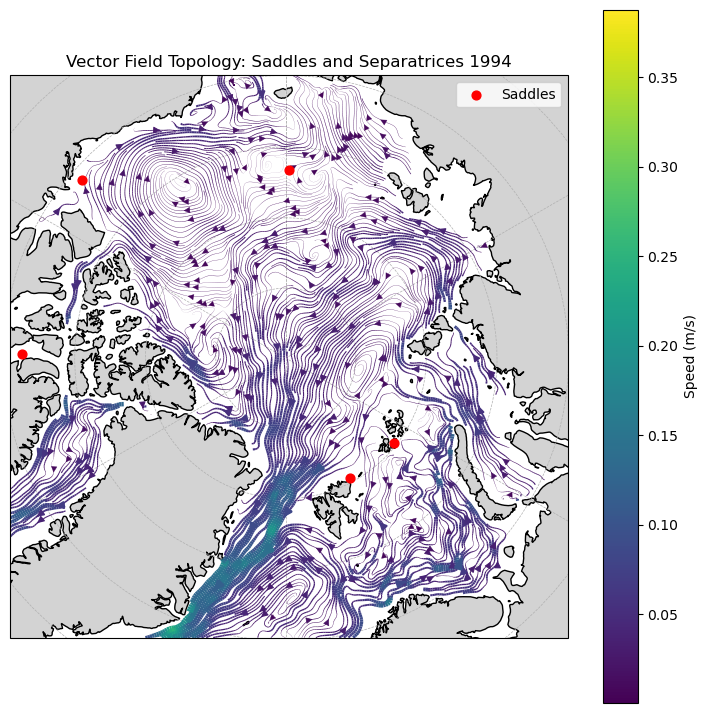

In [19]:

# -------------------------------------------------
# 5. Plot results
# -------------------------------------------------
proj_map = ccrs.NorthPolarStereo()
proj_data = ccrs.PlateCarree()  # because u/v are on lat-lon grid

fig = plt.figure(figsize=(9, 9))
ax = plt.axes(projection=proj_map)
#
# # Focus on Arctic (change for Antarctic)
ax.set_extent([-180, 180, 70, 90], crs=proj_data)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.coastlines(resolution='50m')
ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='--')
u = ds["vxo"].sel(time=year).isel(depth=0).mean("time").compute()  # zonal (east-west)
v = ds["vyo"].sel(time=year).isel(depth=0).mean("time").compute()

ax = add_streamline_plot_to_ax(u,v,ax)

# Saddles
sx = [s[0] for s in saddles]
sy = [s[1] for s in saddles]
plt.scatter(sx, sy, c='red', s=40, label='Saddles', zorder=5,transform=proj_data)

# # Separatrices
# for sep in separatrices:
#     plt.plot(sep[0], sep[1], 'b', linewidth=2, transform=proj_data)

plt.title(f"Vector Field Topology: Saddles and Separatrices {year}")
plt.legend()
plt.savefig(f"saddles_{year}.png")
plt.show()
